Note that undersampling is performed after anomaly label creation.

In [23]:
# Import packages
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Define the source folder
folder = '../out/FullData/'

# Read in the data
df = pd.read_csv(folder + 'cell_labeled.csv')

In [24]:
print(df.shape)
df.head(3)

(12868886, 11)


,timestamp,cell,bts,antenna,carrier,minRSSI,PageSessionTotal,ULvolMByte,AnomalyDay,anomaly,noise
0,2023-09-01 02:30:00+00:00,997_0_0,997,0,0,-109.08,0,0.000000,0,0,0
1,2023-09-01 02:30:00+00:00,580_0_1,580,0,1,-103.58,67,0.150356,0,0,0
2,2023-09-01 02:30:00+00:00,580_1_0,580,1,0,-107.79,0,0.352035,0,0,0


In [26]:
df.dtypes

timestamp           datetime64[ns, UTC]
cell                             object
bts                               int64
antenna                           int64
carrier                           int64
minRSSI                         float64
PageSessionTotal                  int64
ULvolMByte                      float64
AnomalyDay                        int64
anomaly                           int64
noise                             int64
dtype: object

# Funcs

In [14]:
def summary_stats(df):

    total_instances = len(df)
    total_anomalies = df['anomaly'].sum()
    anomaly_percentage = f"{(total_anomalies / total_instances) * 100:.4f} %" if total_instances > 0 else "0.00 %"
    total_cells = df['cell'].nunique()
    cells_with_anomalies = df['cell'][df['anomaly'] == 1].nunique()
    cell_anomaly_percentage = f"{(cells_with_anomalies / total_cells) * 100:.4f} %" if total_cells > 0 else "0.00 %"

    # Calculate total days using the unique dates derived from the timestamp
    total_days = df['timestamp'].dt.date.nunique()
    # Calculate days with anomalies by filtering the DataFrame
    days_with_anomalies = df.loc[df['anomaly'] == 1, 'timestamp'].dt.date.nunique()
    
    # Calculate the percentage of days with anomalies
    day_anomaly_percentage = f"{(days_with_anomalies / total_days) * 100:.4f} %" if total_days > 0 else "0.00 %"

    # Output the summary statistics
    return {
        'Total Instances': total_instances,
        'Total Anomalies': total_anomalies,
        'Anomaly Percentage': anomaly_percentage,
        'Total Cells': total_cells,
        'Cells with Anomalies': cells_with_anomalies,
        'Cell Anomaly Percentage': cell_anomaly_percentage,
        'Total Days': total_days,
        'Days with Anomalies': days_with_anomalies,
        'Day Anomaly Percentage': day_anomaly_percentage
    }

In [31]:
def undersample(df, k):

    """
    Undersample the data by retaining only the points within a k-day window around anomalies.
    Also, remove all cells that do not contain any anomaly instances.
    
    Parameters:
    df : DataFrame
        The input dataset.
    k : int
        The number of days before and after an anomaly to retain.
    
    Returns:
    undersampled_df : DataFrame
        The undersampled dataset.
    """
    
    # Step 1: Identify all cells with anomalies
    anomaly_cells = df.loc[df['anomaly'] == 1, 'cell'].unique()
    
    # Step 2: Filter the DataFrame to keep only data from cells with anomalies
    df_anomalous_cells = df[df['cell'].isin(anomaly_cells)]
    
    # Step 3: Mark all anomaly points and create windows around them (t-k to t+k)
    keep_index = np.zeros(len(df_anomalous_cells), dtype=bool)
    
    # Get unique anomaly timestamps from the filtered data
    anomaly_times = df_anomalous_cells.loc[df_anomalous_cells['anomaly'] == 1, 'timestamp'].values

    anomaly_times = pd.to_datetime(anomaly_times, utc=True)   

    # Create a window of t-k to t+k for each anomaly timestamp
    for anomaly_time in anomaly_times:
        start_time = anomaly_time - pd.Timedelta(days=k)
        end_time = anomaly_time + pd.Timedelta(days=k)
        
        # Mark data within the time window
        keep_index |= (df_anomalous_cells['timestamp'] >= start_time) & (df_anomalous_cells['timestamp'] <= end_time)

    # Step 4: Create the undersampled DataFrame with retained data only
    undersampled_df = df_anomalous_cells[keep_index].copy()
    
    return undersampled_df

In [16]:
def plot_timeseries(df, target_variable):
    # Ensure 'timestamp' is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    num_plots = 2
    split_index = len(df) // num_plots
    
    for i in range(num_plots):
        # Define start and end index for the split
        start_index = i * split_index
        end_index = (i + 1) * split_index if (i + 1) * split_index < len(df) else len(df)
        
        ax = plt.subplot(num_plots, 1, i + 1)
        
        # Plot the target variable as scatter plot
        ax.scatter(df['timestamp'].iloc[start_index:end_index], 
                   df[target_variable].iloc[start_index:end_index], 
                   label=target_variable, alpha=0.5, s=10)
        
        # Plot anomalies (red crosses)
        anomaly_mask = df['anomaly'].iloc[start_index:end_index] == 1
        ax.scatter(df['timestamp'].iloc[start_index:end_index][anomaly_mask], 
                   df[target_variable].iloc[start_index:end_index][anomaly_mask], 
                   color='red', marker='x', label='Anomaly', alpha=0.7, s=50)
        
        # Plot noise (grey crosses)
        noise_mask = df['noise'].iloc[start_index:end_index] == 1
        ax.scatter(df['timestamp'].iloc[start_index:end_index][noise_mask], 
                   df[target_variable].iloc[start_index:end_index][noise_mask], 
                   color='grey', marker='x', label='Noise', alpha=0.7, s=50)
        
        # Title and labels
        ax.set_title(f'{target_variable} Time Series Plot - Part {i + 1}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel(target_variable)
        ax.legend()
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

In [17]:
summary_stats(df)

{'Total Instances': 12868886,
 'Total Anomalies': 11026,
 'Anomaly Percentage': '0.0857 %',
 'Total Cells': 675,
 'Cells with Anomalies': 281,
 'Cell Anomaly Percentage': '41.6296 %',
 'Total Days': 398,
 'Days with Anomalies': 50,
 'Day Anomaly Percentage': '12.5628 %'}

# Option 1

In [32]:
df_1 = undersample(df, 1)

In [33]:
warnings.filterwarnings("ignore")
summary_stats(df_1)

{'Total Instances': 946620,
 'Total Anomalies': 11026,
 'Anomaly Percentage': '1.1648 %',
 'Total Cells': 281,
 'Cells with Anomalies': 281,
 'Cell Anomaly Percentage': '100.0000 %',
 'Total Days': 77,
 'Days with Anomalies': 50,
 'Day Anomaly Percentage': '64.9351 %'}

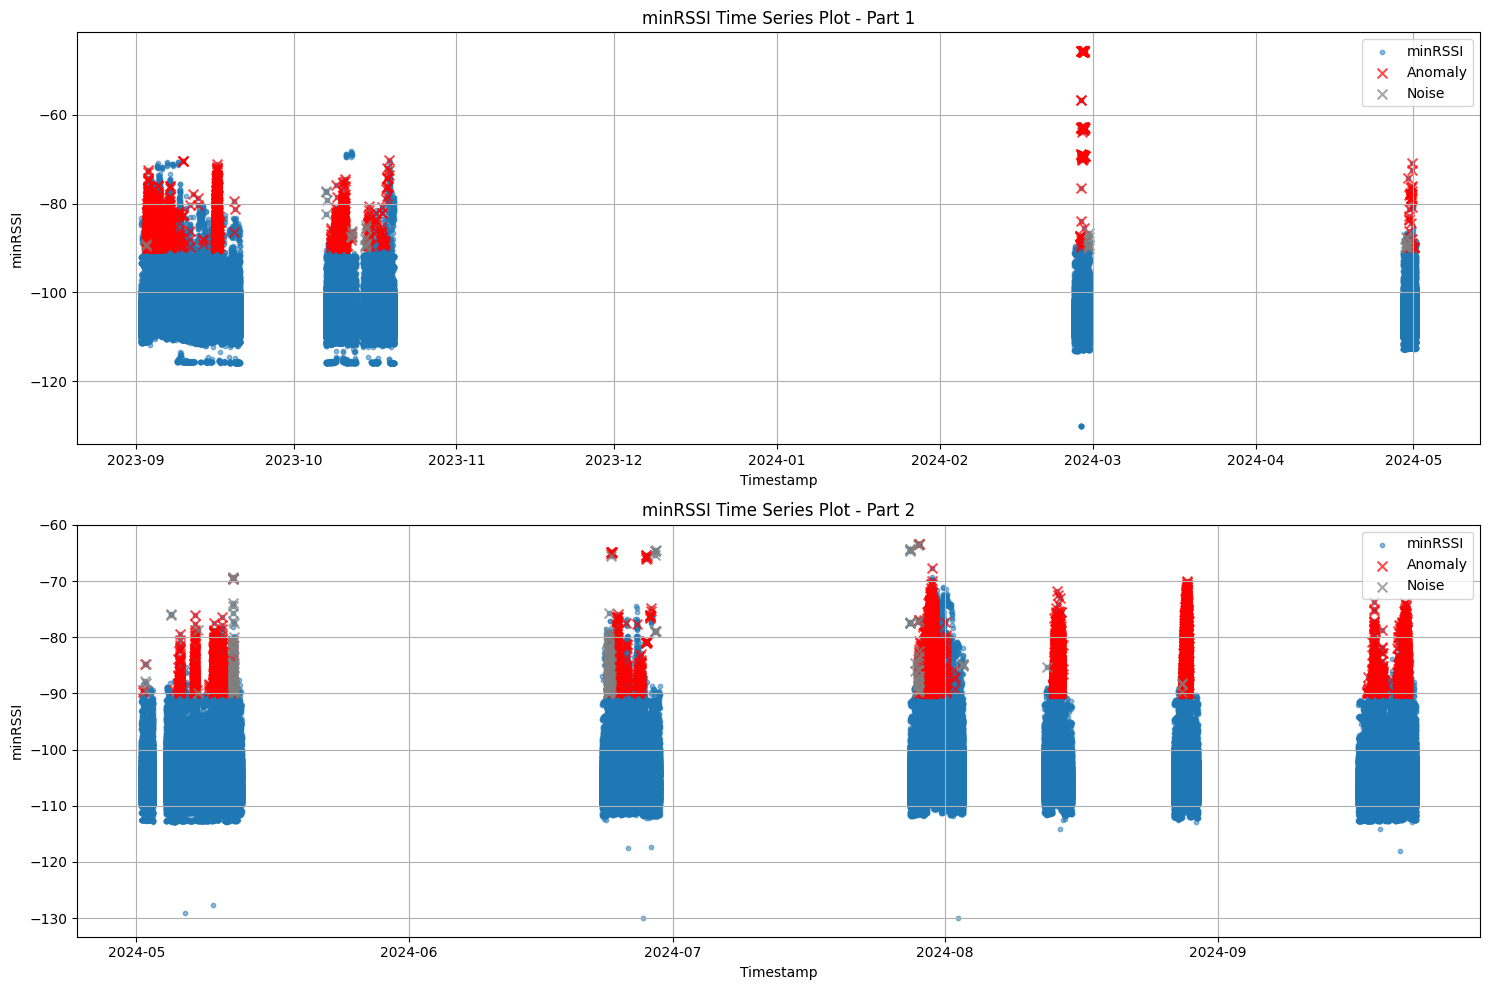

In [34]:
plot_timeseries(df_1, 'minRSSI')

In [35]:
out_folder = '../out/noise+undersampl/'

# Save df_1 as a CSV file
df_1.to_csv(out_folder + 'cell_undersampled_1.csv', index=False)

# option 2 (not used)

In [5]:
# Convert 'timestamp' to datetime if not already done
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define the date ranges to be excluded
date_range_1_start = '2023-10-23'
date_range_1_end = '2024-02-20'
date_range_2_start = '2024-03-01'
date_range_2_end = '2024-04-27'

In [12]:
# Filter out the specified date ranges
df_filtered = df[
    ~((df['timestamp'] >= date_range_1_start) & (df['timestamp'] <= date_range_1_end)) &
    ~((df['timestamp'] >= date_range_2_start) & (df['timestamp'] <= date_range_2_end))
]

# Identify cells with at least one anomaly
cells_with_anomalies = df_filtered[df_filtered['anomaly'] == 1]['cell'].unique()

# Filter the dataframe to keep only instances from cells with anomalies
df_2 = df_filtered[df_filtered['cell'].isin(cells_with_anomalies)]

# remove duplicates
df_2 = df_2.drop_duplicates()

In [13]:
warnings.filterwarnings("ignore")
summary_stats(df_2)

{'Total Instances': 3365668,
 'Total Anomalies': 12264,
 'Anomaly Percentage': '0.3644 %',
 'Total Cells': 382,
 'Cells with Anomalies': 382,
 'Cell Anomaly Percentage': '100.0000 %',
 'Total Days': 221,
 'Days with Anomalies': 51,
 'Day Anomaly Percentage': '23.0769 %'}

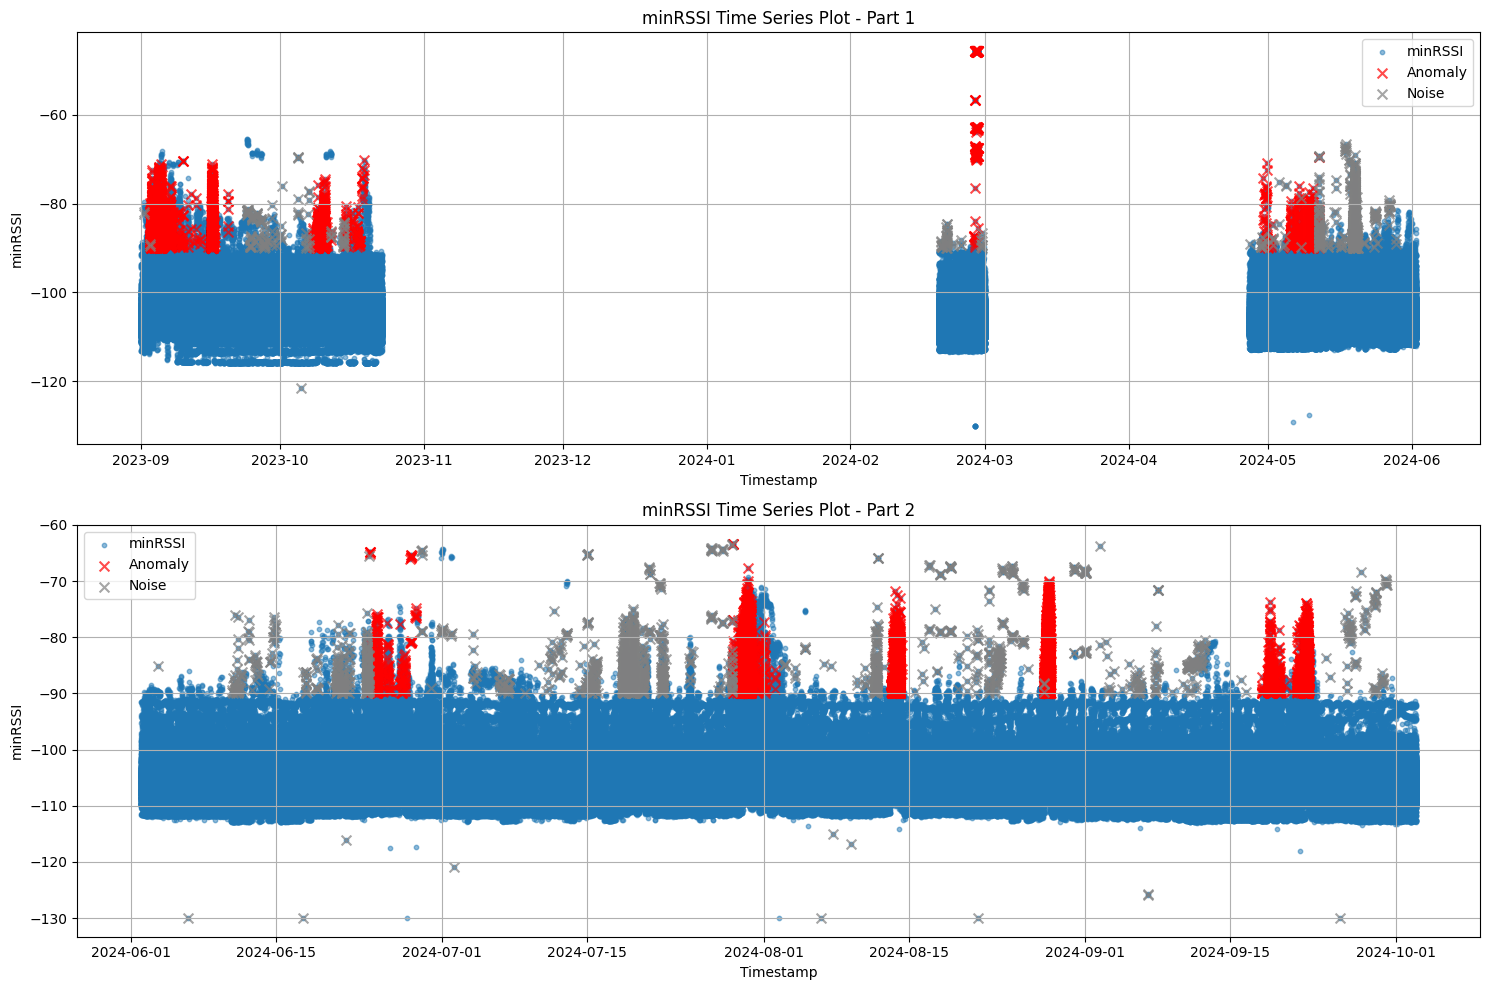

In [14]:
plot_timeseries(df_2, 'minRSSI')

In [16]:
out_folder = '../out/noise+undersampl/'

# Save df_1 as a CSV file
df_2.to_csv(out_folder + 'cell_labeled_undersampled_2.csv', index=False)